**Dataset**: **Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.** \
which collected CO2 samples from March 1958 to December 2001

**Model**: seasonal ARIMA

**Type**: Univariate

**Steps**:
- load the dataset
- explore it
- visualize the data (seasonality, trend, noise?)
- selecting the best parameters(GridSearch), use the parameter pair with the lowest AIC score
- fit the model
- checked fitted model(running model diagnostics) - model is ready!!!
- validate the forecasts on current timeseries data
- evaluate the accuracy/forecasts of model(by Mean Squared Error)
- forecast for future values using the best fitted SARIMA model

In [1]:
# importing required libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm # statsmodels comes with built-in datasets, can load a time-series dataset straight into memory.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [23]:
print(sm.datasets.co2.NOTE)

::

    Number of observations: 2225
    Number of variables: 2
    Variable name definitions:

        date - sample date in YYMMDD format
        co2 - CO2 Concentration ppmv

    The data returned by load_pandas contains the dates as the index.



In [24]:
data = sm.datasets.co2.load_pandas()
y = data.data
y.shape

(2284, 1)

In [25]:
y.head(5)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [4]:
# when working with **time-series data** in Python, ensure that **dates** are used as an index
y.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

- **dtype=datetime[ns]** field confirms that the **index** is at date stamp objects. 
- 2,284 weekly date stamps starting on Saturdays

* Weekly data can be tricky to work with, use the **monthly averages** of the time-series instead 

- use **resample** function, which allows to group the time-series into buckets (1 month), apply a function on each group (mean), and combine the result (one row per group)

In [5]:
# group the data by months using the start of each month as the timestamp
y = y['co2'].resample('MS').mean()

# the term bfill - use the closest non-null value before the missing value point
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


In [6]:
y.shape # after grouping the data by months

(526,)

In [7]:
# slice the dataset to only data after 1990
y['1990':]

1990-01-01    353.650
1990-02-01    354.650
1990-03-01    355.480
1990-04-01    356.175
1990-05-01    357.075
               ...   
2001-08-01    369.425
2001-09-01    367.880
2001-10-01    368.050
2001-11-01    369.375
2001-12-01    371.020
Freq: MS, Name: co2, Length: 144, dtype: float64

In [8]:
# slice between October 1995 and October 1996
y['1995-10-01':'1996-10-01']

1995-10-01    357.850
1995-11-01    359.475
1995-12-01    360.700
1996-01-01    362.025
1996-02-01    363.175
1996-03-01    364.060
1996-04-01    364.700
1996-05-01    365.325
1996-06-01    364.880
1996-07-01    363.475
1996-08-01    361.320
1996-09-01    359.400
1996-10-01    359.625
Freq: MS, Name: co2, dtype: float64

#### Visualize the data to check
- seasonality: data display a clear **periodic pattern**?
- trend: data follow a consistent **upwards or downward** slope?
- noise: any outlier points or missing values that are not consistent with the rest of the data?

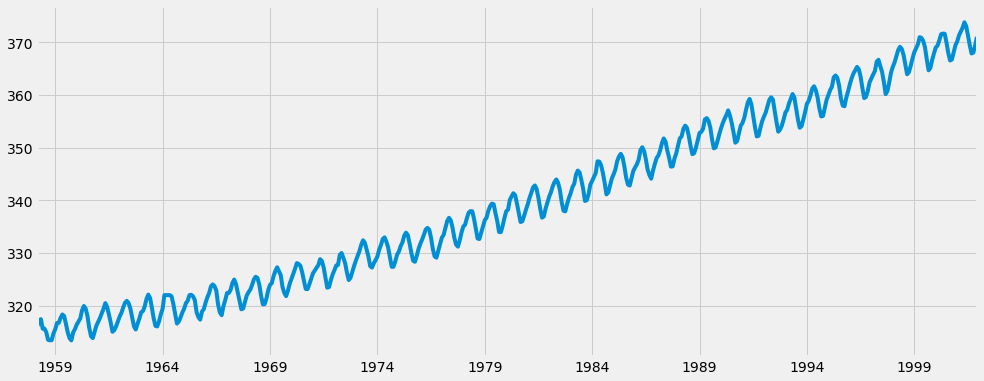

In [9]:
y.plot(figsize=(15, 6))
plt.show()

<i>The plot shows obvious seasonality pattern and  an **overall increasing trend**.

#### Visualize the data using time-series decomposition
to quickly identify a changing **mean or variation** in the data / to understand the structure of the time-series

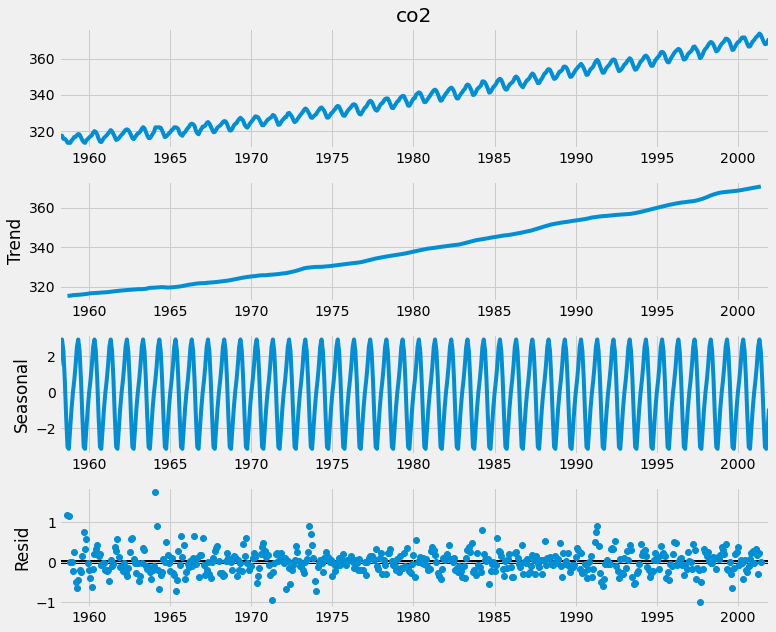

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

It says the upwards trend, along with its yearly seasonality.

#### Parameters of ARIMA model 

**ARIMA(p,d,q)** - non-seasonal parameters \
**SARIMA(p,d,q)(P,D,Q)s]**, <i>s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.)

- p is the auto-regressive. The **effect of past values** into the model. Eg ..<i>likely to be warm tomorrow if it has been warm the past 3 days.
- d is the integrated. The amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Eg .. <i>likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
- q is the moving average. The **error** of the model -  a linear combination of the error values observed at previous time points in the past.

### Selecting optimal set of parameters

the correct parametrization of ARIMA models can be a painstaking manual process that requires **domain expertise and time**. 

**GridSearch(or hyperparameter optimization)** for model selection - to select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.

In [11]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


AIC(Akaike Information Criterion) \
how well a model fits the data while taking into account the overall complexity of the model.

larger AIC - model that uses lots of features to fit with the data \
lower AIC - ...... fewer features ...... 

**will take lowest AIC value**

In [12]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624044102
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.8282341411793
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.711172764109
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320058
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878474543522
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578977897923
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912899374
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754117362
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327700222
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.194106730522
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716868783
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1099.2611023194736
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:782.5930728936784
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893625127
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912987792731
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.808692302429
SARIMAX(0, 1, 0)x(0, 0,

SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 277.78.

### Fitting an ARIMA Time Series Model

In [13]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3179      0.092      3.443      0.001       0.137       0.499
ma.L1         -0.6255      0.076     -8.177      0.000      -0.775      -0.476
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8766      0.026    -33.754      0.000      -0.927      -0.826
sigma2         0.0971      0.004     22.638      0.000       0.089       0.106


- **coef** column shows the **weight** (i.e. importance) of each feature and how each one impacts the time series
- **P>|z|** column informs us of the **significance** of each feature weight.

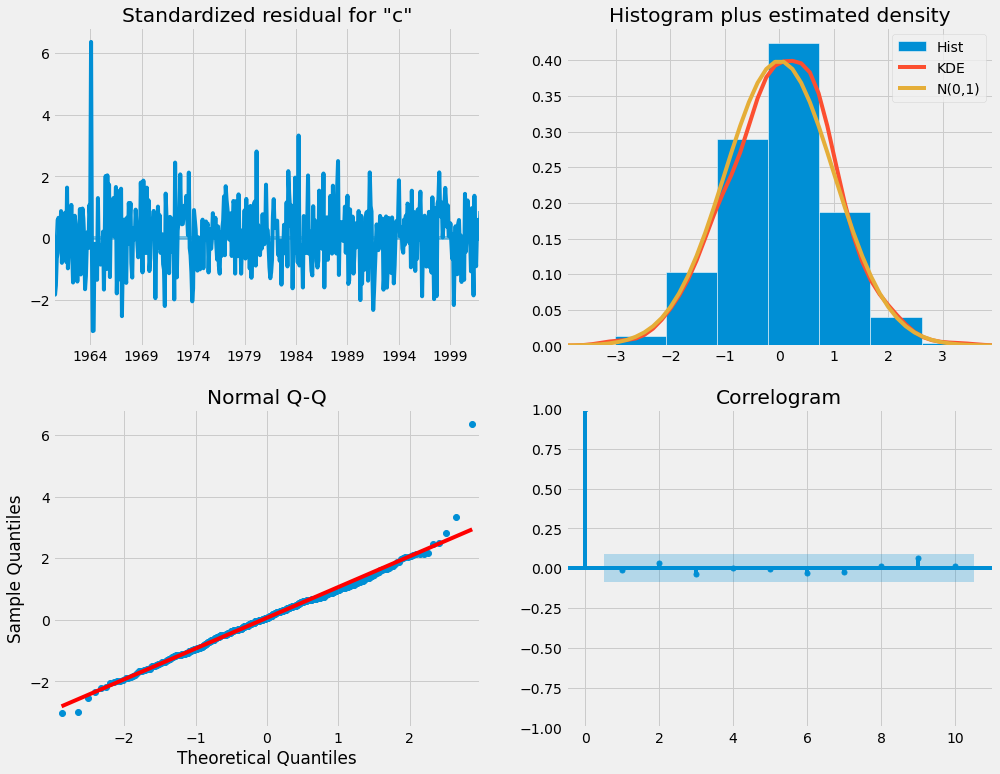

In [14]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### Validating Forecasts

##### One-step ahead forecasts 
forecasts at each point are generated using the full history **up to that point**

In [15]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False) # forecasts to start at January 1998
pred_ci = pred.conf_int()

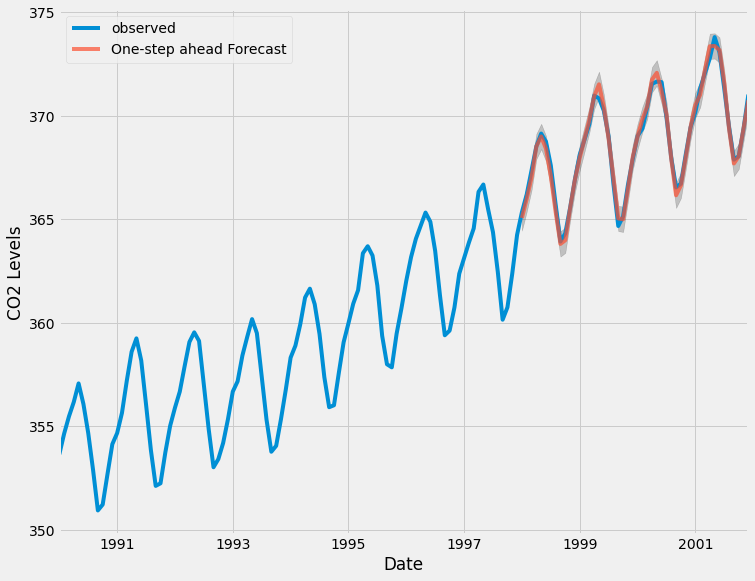

In [16]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [17]:
# MSE (Mean Squared Error), which summarizes the average error of the forecasts
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

##### Dynamic forecasts
only use information from the time series **up to a certain point** \
then forecasts are generated using values from previous forecasted time points

In [18]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

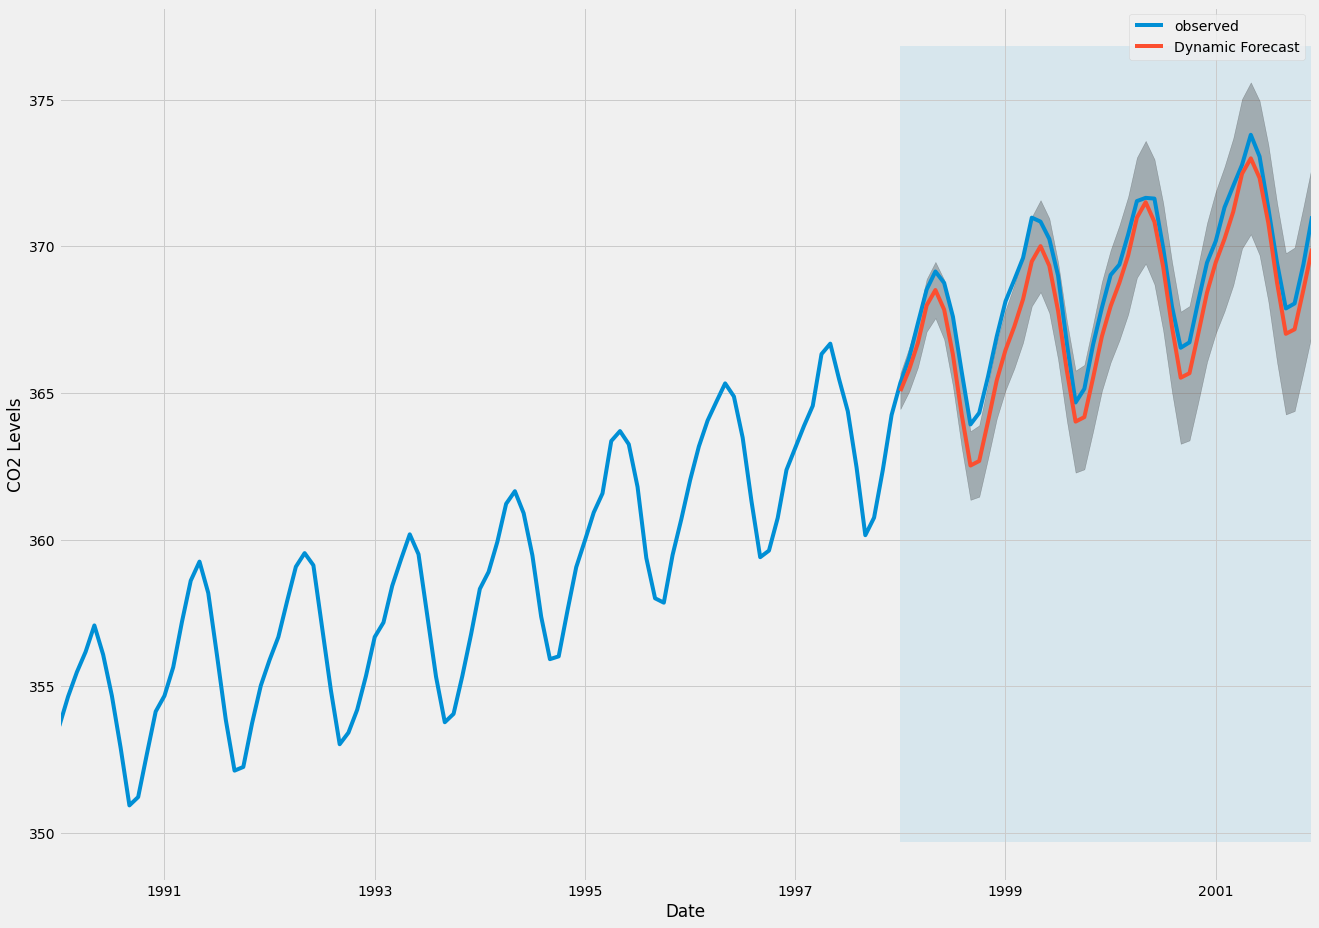

In [19]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [20]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


### Producing and Visualizing Forecasts

In [21]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

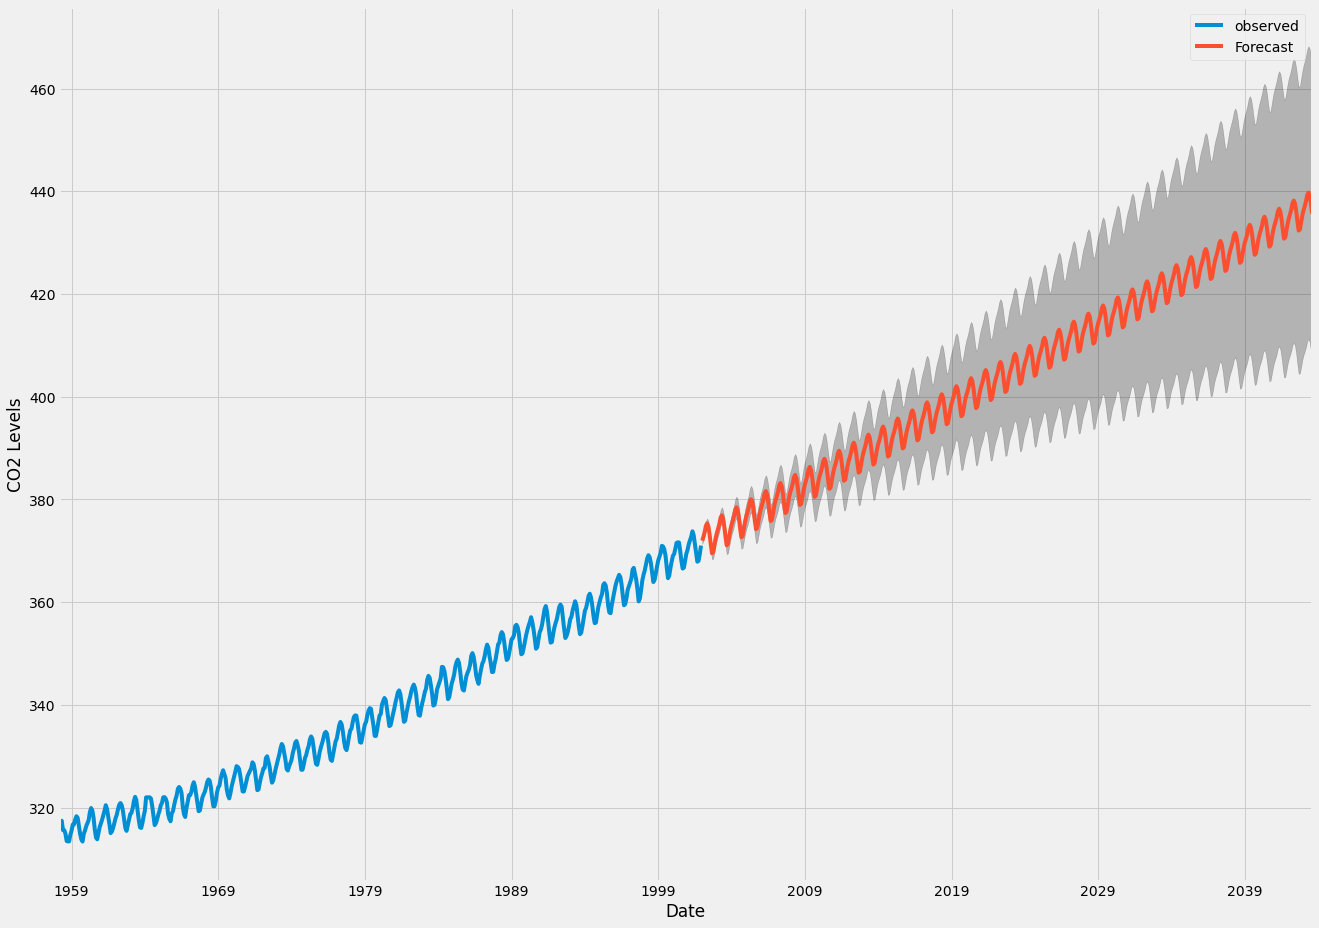

In [22]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

The resulted time series is expected to continue increasing at a steady pace.

Reference Src : https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3